## 根据纽约出租车的运营数据，针对客户旅途时间展开分析与建模。

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64

In [3]:
df = pd.read_csv('train.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


太远地方的就先去掉啦

In [4]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude> xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude> xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude> ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude> ylim[0]) & (df.dropoff_latitude < ylim[1])]

上下车地点集中区域

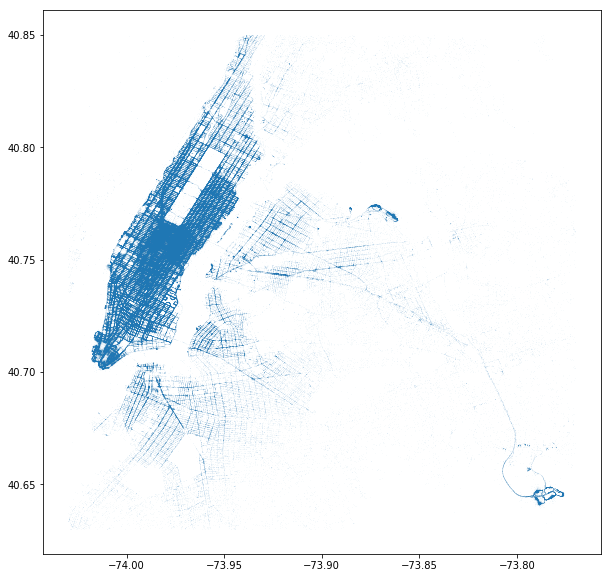

In [5]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.show()

根据上下车的地点，将区域分一下，用聚类来试试

In [6]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

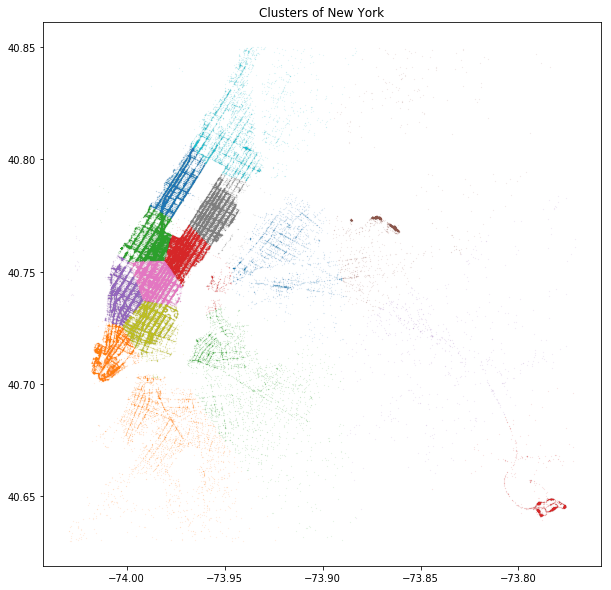

In [7]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

给区域来个标记吧

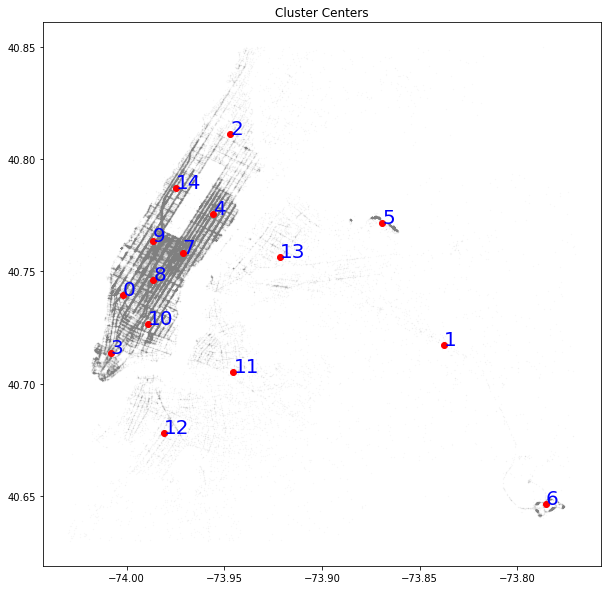

In [9]:
fig,ax = plt.subplots(figsize = (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

In [10]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour )

In [11]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))

loc_df = loc_df.sample(5000)

展示了方向与趋势，箭头的宽度与车流成正比

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation2.html', writer='imagemagick', fps=2)

e:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
e:\ProgramData\Anaconda3\lib\site-packages\matplotlib\animation.py:1218: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


邻居分析

In [17]:
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-parkslope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',-73.9745967889:'Upper West Side'}

In [18]:
rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [19]:
df['pickup_neighborhood'] = neigh.predict(df.pickup_longitude.reshape(-1,1))
df['dropoff_neighborhood'] = neigh.predict(df.dropoff_longitude.reshape(-1,1))

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))

e:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
e:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [20]:
rides_df.head()

,Chelsea,Queens,JFK,Midtown-North-West,East Village,Midtown-North-East,Brooklyn-parkslope,LaGuardia,Midtown,Downtown,Queens-Astoria,Harlem,Uppe East Side,Brooklyn-Williamsburgt,Upper West Side,name
0,28526,228,950,18989,10622,7657,6141,1497,35963,22084,2119,2209,7998,2317,8742,Chelsea
1,27,375,93,55,37,20,5,120,33,24,43,15,43,15,41,Queens
2,1887,1221,2779,3578,2116,2351,743,1463,3207,1576,1749,993,2847,1244,2208,JFK
3,17496,416,2183,30833,13214,27005,6747,4206,35307,10196,2940,4654,22343,3898,23537,Midtown-North-West
4,10616,186,1168,13532,5619,8030,2622,2073,16225,5980,1625,1793,7099,1704,9138,East Village


In [21]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

trace = go.Heatmap(z= np.array(rides_df.as_matrix()),
                  x = rides_df.columns[:-1],
                  y = rides_df.columns)
layout = dict(
    title = ' <b>Neighborhoods Interaction</b>',
    titlefont = dict(
    size = 30,
    color = ('rgb(100,100,100)')),
    margin = dict(t=100,r=100,b=100,l=150),
        yaxis = dict(
            title = ' <b> From </b>'),
        xaxis = dict(
            title = '<b> To </b>'))
data=[trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

进出分析

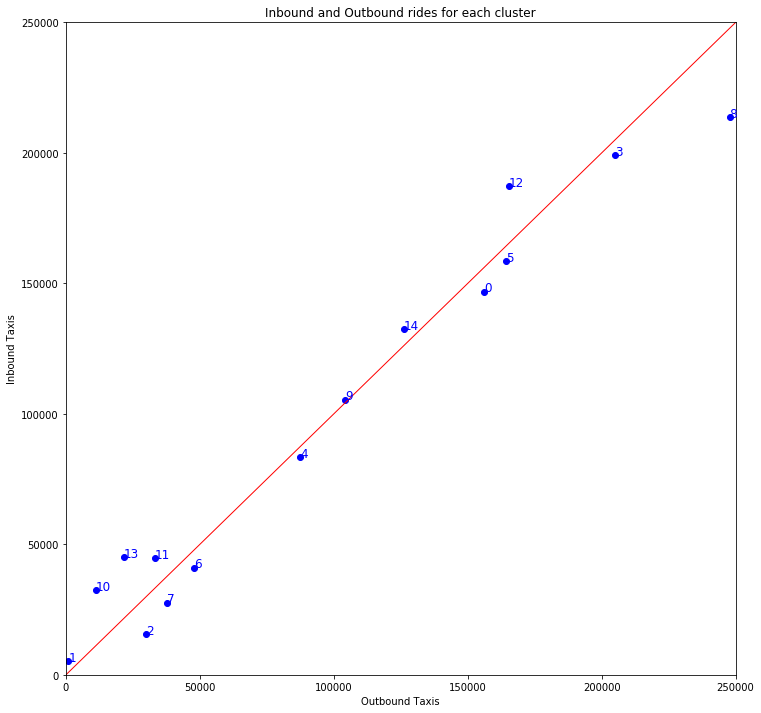

In [24]:
fig,ax = plt.subplots(figsize = (12,12))
for i in range(len(rides_df)):  
    ax.plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax.plot([0,250000],[0,250000], color = 'r', linewidth = 1)
ax.grid('off')
ax.set_xlim([0,250000])
ax.set_ylim([0,250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')
plt.show()

我们可以看到，每个地区的出入的比率是相对平衡的。

In [1]:
import pandas as pd  #pandas for using dataframe and reading csv 
import numpy as np   #numpy for vector operations and basic maths 
#import simplejson    #getting JSON in simplified format
import urllib        #for url stuff
#import gmaps       #for using google maps to visulalize places on maps
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations
import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os  # for os commands
from scipy.misc import imread, imresize, imsave  # for plots 
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import base64
import warnings
warnings.filterwarnings("ignore")
output_notebook()
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

Loading BokehJS ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


数据读取与特征选择

In [2]:
s = time.time()
train_fr_1 = pd.read_csv('./data/fastest_routes_train_part_1.csv')
train_fr_2 = pd.read_csv('./data/fastest_routes_train_part_2.csv')
train_fr = pd.concat([train_fr_1, train_fr_2])
train_fr_new = train_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
train_df = pd.read_csv('./data/train.csv')
train = pd.merge(train_df, train_fr_new, on = 'id', how = 'left')
train_df = train.copy()
end = time.time()
print("Time taken by above cell is {}.".format((end-s)))
train_df.head()

Time taken by above cell is 14.2900869846344.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1614.9,140.1,5.0


数据检查

In [3]:
# checking if Ids are unique, 
train_data = train_df.copy()
print("Number of columns and rows and columns are {} and {} respectively.".format(train_data.shape[1], train_data.shape[0]))
if train_data.id.nunique() == train_data.shape[0]:
    print("Train ids are unique")
print("Number of Nulls - {}.".format(train_data.isnull().sum().sum()))

Number of columns and rows and columns are 14 and 1458644 respectively.
Train ids are unique
Number of Nulls - 3.


旅行持续时间log展示

Time taken by above cell is 0.2782478332519531.


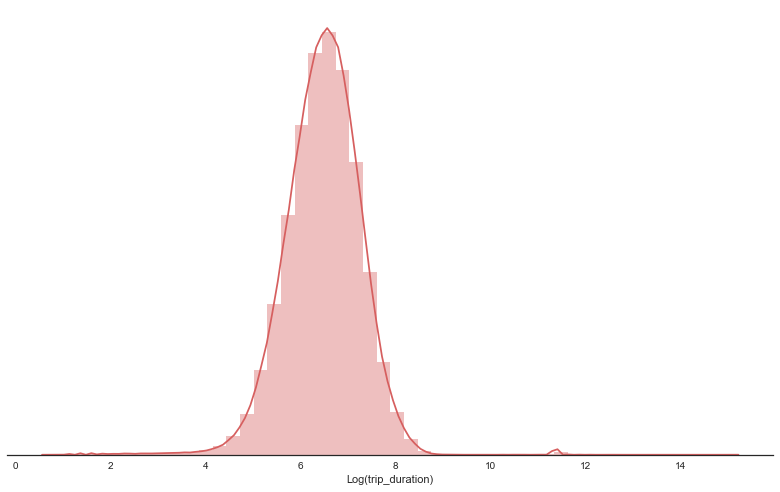

In [4]:
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train_df['trip_duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

正太分布的，有个别时间有点高的离谱了。。。有个别的神速了

In [5]:
print ('大部分的旅行时间是在：',np.exp(4)/60,np.exp(8)/60)
print ('比较吊的。。。',np.exp(2)/60,np.exp(12)/60)

大部分的旅行时间是在： 0.909969167219 49.6826331174
比较吊的。。。 0.123150934982 2712.57985698


数据提供的位置

Time taken by above cell is 1.2390995025634766.


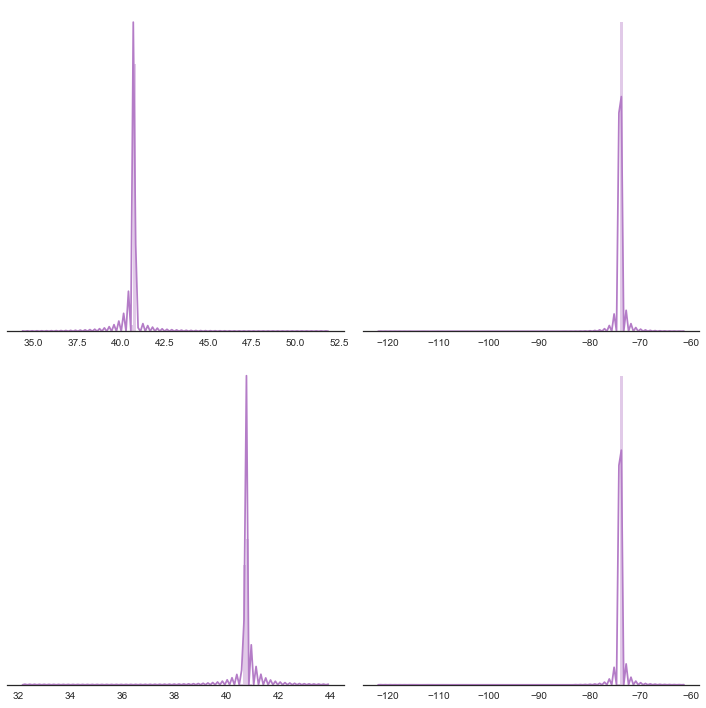

In [6]:
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train_df['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_df['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(train_df['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_df['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

有些位置是不是太偏僻了，还是统计误差啊，去掉那些离谱的

纬度控制在40.6到40.9
经度控制在-74.05到-73.70

Time taken by above cell is 1.8928685188293457.
1452385 1458644


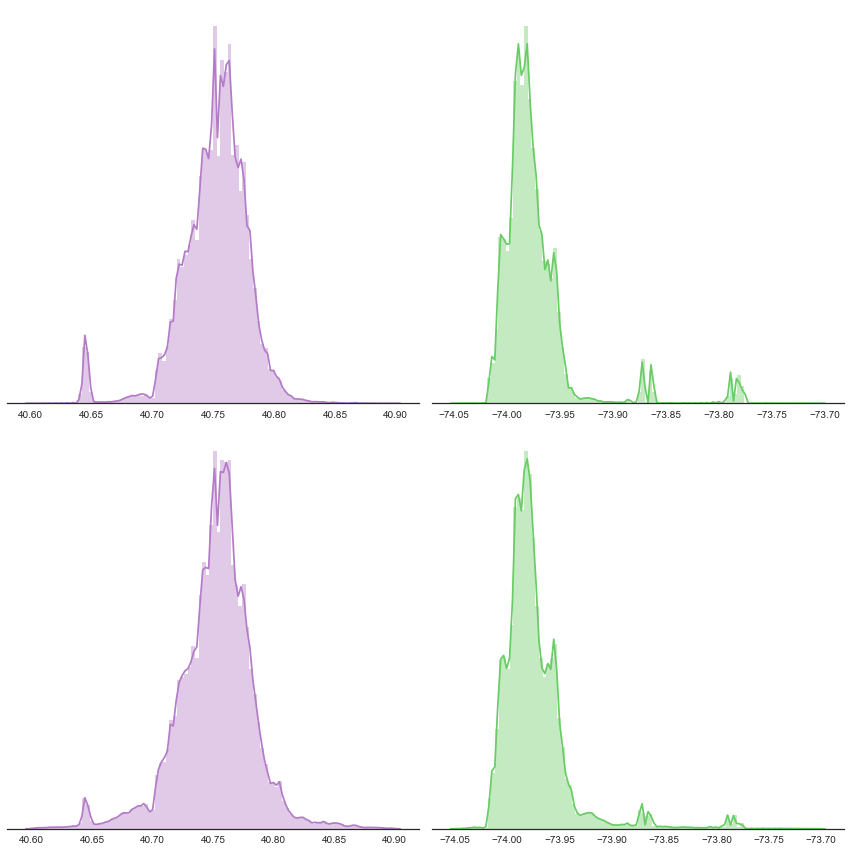

In [7]:
start = time.time()
df = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
train_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
print(df.shape[0], train_data.shape[0])
plt.show()

以黑色为背景

In [8]:
temp = train_data.copy()
start = time.time()
rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))

train_data_new.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,total_distance,total_travel_time,number_of_steps,pick_lat_new,drop_lat_new,pick_lon_new,drop_lon_new
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2009.1,164.9,5.0,1679,1656,678,853
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2513.2,332.0,6.0,1385,1311,695,505
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11060.8,767.6,16.0,1639,1100,709,446
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1779.4,235.8,4.0,1199,1067,399,377
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1614.9,140.1,5.0,1932,1825,769,770


In [9]:
summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head()

,pick_lat_new,pick_lon_new,id
0,2,544,1
1,6,840,1
2,8,454,1
3,9,706,1
4,17,1030,1


Time taken by above cell is 4.935481071472168.


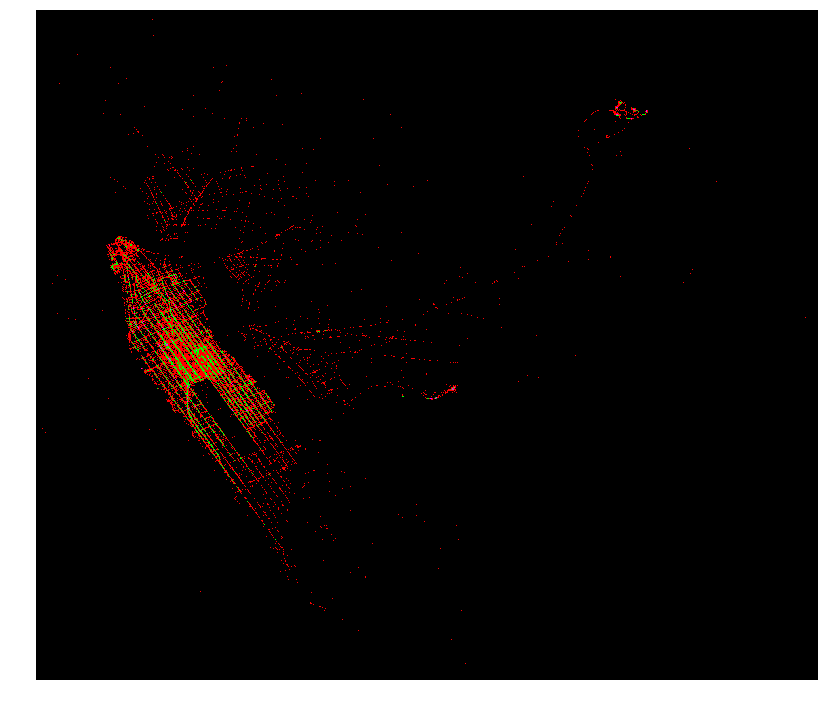

In [10]:
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//50) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 255
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

- 红点表示在给定数据中的1-10次行程具有该点作为起始点
- 绿点表示在给定数据中超过10-50次旅行具有该点作为起始点
- 黄点表示在给定数据中超过50次以上的行程具有该点作为起始点

特征工程：
选择对旅途时间有影响的因素

In [11]:
#空间地理距离
start = time.time()
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

import math
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)))

Time taken by above cell is 0.0.


In [12]:
start = time.time()
train_data = temp.copy()
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_month'] = train_data['pickup_datetime'].dt.month
train_data.loc[:, 'hour'] = train_data['pickup_datetime'].dt.hour
train_data.loc[:, 'week_of_year'] = train_data['pickup_datetime'].dt.weekofyear
train_data.loc[:, 'day_of_year'] = train_data['pickup_datetime'].dt.dayofyear
train_data.loc[:, 'day_of_week'] = train_data['pickup_datetime'].dt.dayofweek
train_data.loc[:,'hvsine_pick_drop'] = haversine_(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'bearing'] = bearing_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

end = time.time()
print("Time taken by above cell is {}.".format(end-start))


Time taken by above cell is 2.7582061290740967.


In [13]:
start = time.time()
def color(hour):
    """function for color change in animation"""
    return(10*hour)

def Animation(hour, temp, rgb):
    """Function to generate return a pic of plotings"""
    #ax.clear()
    train_data_new = temp.loc[temp['hour'] == hour]
    start = time.time()
    rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
    rgb[..., 0] = 0
    rgb[..., 1] = 0
    rgb[..., 2] = 0
    train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
    train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
    train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
    train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))

    summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

    summary_plot.reset_index(inplace = True)
    summary_plot.head(120)
    lat_list = summary_plot['pick_lat_new'].unique()
    for i in lat_list:
        #print(i)
        lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
        unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
        for j in lon_list:
            #j = int(j)
            a = unit[lon_list.index(j)]
            #print(a)
            if (a//50) >0:
                rgb[i][j][0] = 255 - color(hour)
                rgb[i,j, 1] = 255 - color(hour)
                rgb[i,j, 2] = 0 + color(hour)
            elif (a//10)>0:
                rgb[i,j, 0] = 0 + color(hour)
                rgb[i,j, 1] = 255 - color(hour)
                rgb[i,j, 2] = 0 + color(hour)
            else:
                rgb[i,j, 0] = 255 - color(hour)
                rgb[i,j, 1] = 0 + color(hour)
                rgb[i,j, 2] = 0 + color(hour)
    #fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
    end = time.time()
    print("Time taken by above cell is {} for {}.".format((end-start), hour))
    return(rgb)
end = time.time()
print("Time taken by above cell is {}.".format(end -start))

Time taken by above cell is 0.0.


In [14]:
start = time.time()
images_list=[]
train_data_new['pickup_datetime'] = pd.to_datetime(train_data_new.pickup_datetime)
train_data_new.loc[:, 'hour'] = train_data_new['pickup_datetime'].dt.hour

for i in list(range(0, 24)):
    im = Animation(i, train_data_new, rgb.copy())
    images_list.append(im)
end = time.time()
print("Time taken by above cell is {}.".format(end -start))

Time taken by above cell is 1.6389679908752441 for 0.
Time taken by above cell is 1.4990801811218262 for 1.
Time taken by above cell is 1.3021628856658936 for 2.
Time taken by above cell is 1.275221347808838 for 3.
Time taken by above cell is 1.2565860748291016 for 4.
Time taken by above cell is 1.2167680263519287 for 5.
Time taken by above cell is 1.4150054454803467 for 6.
Time taken by above cell is 1.555870771408081 for 7.
Time taken by above cell is 1.5852866172790527 for 8.
Time taken by above cell is 1.4900872707366943 for 9.
Time taken by above cell is 1.457101583480835 for 10.
Time taken by above cell is 1.4791648387908936 for 11.
Time taken by above cell is 1.4905309677124023 for 12.
Time taken by above cell is 1.471121072769165 for 13.
Time taken by above cell is 1.5651226043701172 for 14.
Time taken by above cell is 1.582446575164795 for 15.
Time taken by above cell is 1.5430455207824707 for 16.
Time taken by above cell is 1.8448097705841064 for 17.
Time taken by above cell 

In [15]:
start = time.time()
def build_gif(imgs = images_list, show_gif=False, save_gif=True, title=''):
    """function to create a gif of heatmaps"""
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    ax.set_axis_off()
    hr_range = list(range(0,24))
    def show_im(pairs):
        ax.clear()
        ax.set_title('Absolute Traffic - Hour ' + str(int(pairs[0])) + ':00')
        ax.imshow(pairs[1])
        ax.set_axis_off() 
    pairs = list(zip(hr_range, imgs))
    #ims = map(lambda x: (ax.imshow(x), ax.set_title(title)), imgs)
    im_ani = animation.FuncAnimation(fig, show_im, pairs,interval=500, repeat_delay=0, blit=False)
    plt.cla()
    if save_gif:
        im_ani.save('animation.html', writer='imagemagick') #, writer='imagemagick'
    if show_gif:
        plt.show()
    return
end = time.time()
print("Time taken by above cell is {}".format(end-start))

Time taken by above cell is 0.0


7.758885860443115


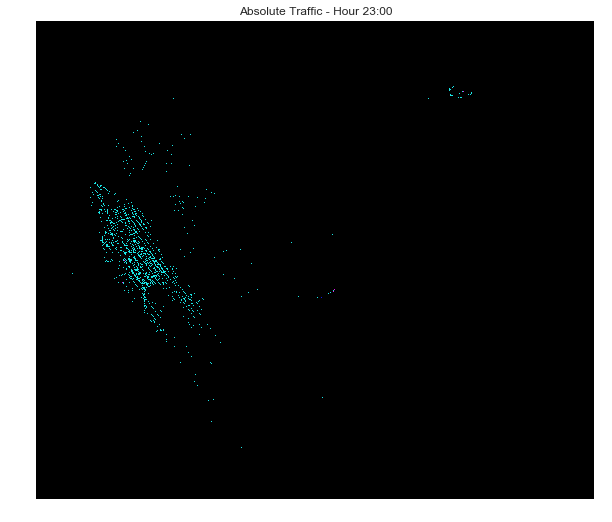

In [16]:
start = time.time()
build_gif()
end = time.time()
print(end-start)

特征解释

0.24365997314453125


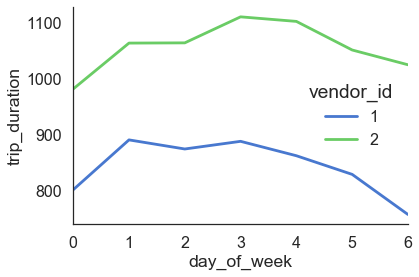

In [17]:
start = time.time()
summary_wdays_avg_duration = pd.DataFrame(train_data.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)
end = time.time()
print(end - start)

显而易见的是，出租车1类在一周中的所有日子里花费的时间都多于出租车2类，平均差不多多了250秒

vovin plot

1452385


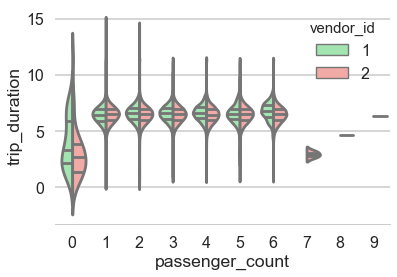

In [18]:
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_context("poster")
train_data2 = train_data.copy()
train_data2['trip_duration']= np.log(train_data['trip_duration'])
sns.violinplot(x="passenger_count", y="trip_duration", hue="vendor_id", data=train_data2, split=True,
               inner="quart",palette={1: "g", 2: "r"})

sns.despine(left=True)
print(df.shape[0])

- 空载是在刷单吗。。。
- 载客人数的分布情况差不多|

Box-Plots

3526282
Time taken by above cell is 0.3499119281768799.


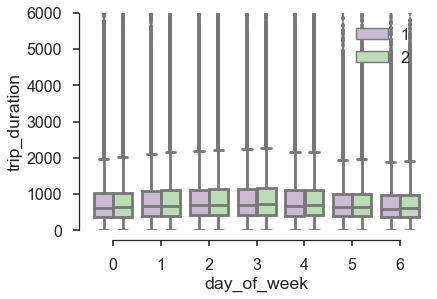

In [19]:
start = time.time()
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="day_of_week", y="trip_duration", hue="vendor_id", data=train_data, palette="PRGn")
plt.ylim(0, 6000)
plt.legend(loc = 'upper right')
sns.despine(offset=10, trim=True)
print(train_data.trip_duration.max())
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

- 周六日的出行时间更短一些

line-plots

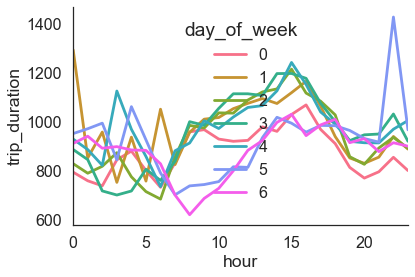

In [20]:
summary_hour_duration = pd.DataFrame(train_data.groupby(['day_of_week','hour'])['trip_duration'].mean())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="hour", unit = "unit", condition="day_of_week", value="trip_duration")
sns.despine(bottom = False)

- 周六日在5点到15点之间还是比较快的

聚类

In [21]:
start = time.time()
def assign_cluster(df, k):
    """function to assign clusters """
    df_pick = df[['pickup_longitude','pickup_latitude']]
    df_drop = df[['dropoff_longitude','dropoff_latitude']]
    """I am using initialization as from the output of
    k-means from my local machine to save time in this kernel"""
    init = np.array([[ -73.98737616,   40.72981533],
       [-121.93328857,   37.38933945],
       [ -73.78423222,   40.64711269],
       [ -73.9546417 ,   40.77377538],
       [ -66.84140269,   36.64537175],
       [ -73.87040541,   40.77016484],
       [ -73.97316185,   40.75814346],
       [ -73.98861094,   40.7527791 ],
       [ -72.80966949,   51.88108444],
       [ -76.99779701,   38.47370625],
       [ -73.96975298,   40.69089596],
       [ -74.00816622,   40.71414939],
       [ -66.97216034,   44.37194443],
       [ -61.33552933,   37.85105133],
       [ -73.98001393,   40.7783577 ],
       [ -72.00626526,   43.20296402],
       [ -73.07618713,   35.03469086],
       [ -73.95759366,   40.80316361],
       [ -79.20167796,   41.04752096],
       [ -74.00106031,   40.73867723]])
    k_means_pick = KMeans(n_clusters=k, init=init, n_init=1)
    k_means_pick.fit(df_pick)
    clust_pick = k_means_pick.labels_
    df['label_pick'] = clust_pick.tolist()
    df['label_drop'] = k_means_pick.predict(df_drop)
    return df, k_means_pick

end = time.time()
print("time taken by thie script by now is {}.".format(end-start))

time taken by thie script by now is 0.0005013942718505859.


In [22]:
start = time.time()
train_cl, k_means = assign_cluster(train_data, 20)  # make it 100 when extracting features 
centroid_pickups = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_pick_long', 'centroid_pick_lat'])
centroid_dropoff = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_drop_long', 'centroid_drop_lat'])
centroid_pickups['label_pick'] = centroid_pickups.index
centroid_dropoff['label_drop'] = centroid_dropoff.index
#centroid_pickups.head()
train_cl = pd.merge(train_cl, centroid_pickups, how='left', on=['label_pick'])
train_cl = pd.merge(train_cl, centroid_dropoff, how='left', on=['label_drop'])
#train_cl.head()
end = time.time()
print("Time taken in clustering is {}.".format(end - start))

Time taken in clustering is 2.5313637256622314.


聚类相关特征

- 上下客点所在簇中心点的距离
- 方向特征 - 集群质心之间的方向

In [23]:
start = time.time()
train_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)

train_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl['speed_hvsn'] = train_cl.hvsine_pick_drop/train_cl.total_travel_time
train_cl['speed_manhtn'] = train_cl.manhtn_pick_drop/train_cl.total_travel_time
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))
train_cl.head()

Time Taken by above cell is 3.551389694213867.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,hvsine_drop_cent_d,hvsine_cent_p_cent_d,manhtn_pick_cent_p,manhtn_drop_cent_d,manhtn_cent_p_cent_d,bearing_pick_cent_p,bearing_drop_cent_p,bearing_cent_p_cent_d,speed_hvsn,speed_manhtn
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.098585,2.319857,1.338601,1.549840,2.822553,8.812218,-138.980503,165.640915,0.009087,0.010524
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0.845448,1.520191,1.573052,0.968702,2.144236,-149.031278,-9.113659,-49.174617,0.005438,0.007321
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0.508922,5.718571,1.135490,0.690697,7.848844,142.642889,-28.669171,-148.907292,0.008318,0.010687
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0.888828,0.000000,0.805089,1.161466,0.000000,166.837718,22.515049,0.000000,0.006300,0.007046
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0.755820,0.000000,2.237846,1.060322,0.000000,-160.438403,-127.746230,0.000000,0.008484,0.008561


聚类可视化展示

In [24]:
start = time.time()
def cluster_summary(sum_df):
    """function to calculate summary of given list of clusters """
    #agg_func = {'trip_duration':'mean','label_drop':'count','bearing':'mean','id':'count'} # that's how you use agg function with groupby
    summary_avg_time = pd.DataFrame(sum_df.groupby('label_pick')['trip_duration'].mean())
    summary_avg_time.reset_index(inplace = True)
    summary_pref_clus = pd.DataFrame(sum_df.groupby(['label_pick', 'label_drop'])['id'].count())
    summary_pref_clus = summary_pref_clus.reset_index()
    summary_pref_clus = summary_pref_clus.loc[summary_pref_clus.groupby('label_pick')['id'].idxmax()]
    summary =pd.merge(summary_avg_time, summary_pref_clus, how = 'left', on = 'label_pick')
    summary = summary.rename(columns={'trip_duration':'avg_triptime'})
    return summary
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))

Time Taken by above cell is 0.0005021095275878906.


In [25]:
import folium
def show_fmaps(train_data, path=1):
    """function to generate map and add the pick up and drop coordinates
    1. Path = 1 : Join pickup (blue) and drop(red) using a straight line
    """
    full_data = train_data
    summary_full_data = pd.DataFrame(full_data.groupby('label_pick')['id'].count())
    summary_full_data.reset_index(inplace = True)
    summary_full_data = summary_full_data.loc[summary_full_data['id']>70000]
    map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=10,tiles='Stamen Toner') # manually added centre
    new_df = train_data.loc[train_data['label_pick'].isin(summary_full_data.label_pick.tolist())].sample(50)
    new_df.reset_index(inplace = True, drop = True)
    for i in range(new_df.shape[0]):
        pick_long = new_df.loc[new_df.index ==i]['pickup_longitude'].values[0]
        pick_lat = new_df.loc[new_df.index ==i]['pickup_latitude'].values[0]
        dest_long = new_df.loc[new_df.index ==i]['dropoff_longitude'].values[0]
        dest_lat = new_df.loc[new_df.index ==i]['dropoff_latitude'].values[0]
        folium.Marker([pick_lat, pick_long]).add_to(map_1)
        folium.Marker([dest_lat, dest_long]).add_to(map_1)
    return map_1

重点的clusters：大于70000个记录

In [26]:
def clusters_map(clus_data, full_data, tile = 'OpenStreetMap', sig = 0, zoom = 12, circle = 0, radius_ = 30):
    """ function to plot clusters on map"""
    map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=zoom,tiles= tile) # 'Mapbox' 'Stamen Toner'
    summary_full_data = pd.DataFrame(full_data.groupby('label_pick')['id'].count())
    summary_full_data.reset_index(inplace = True)
    if sig == 1:
        summary_full_data = summary_full_data.loc[summary_full_data['id']>70000]
    sig_cluster = summary_full_data['label_pick'].tolist()
    clus_summary = cluster_summary(full_data)
    for i in sig_cluster:
        pick_long = clus_data.loc[clus_data.index ==i]['centroid_pick_long'].values[0]
        pick_lat = clus_data.loc[clus_data.index ==i]['centroid_pick_lat'].values[0]
        clus_no = clus_data.loc[clus_data.index ==i]['label_pick'].values[0]
        most_visited_clus = clus_summary.loc[clus_summary['label_pick']==i]['label_drop'].values[0]
        avg_triptime = clus_summary.loc[clus_summary['label_pick']==i]['avg_triptime'].values[0]
        pop = 'cluster = '+str(clus_no)+' & most visited cluster = ' +str(most_visited_clus) +' & avg triptime from this cluster =' + str(avg_triptime)
        if circle == 1:
            folium.CircleMarker(location=[pick_lat, pick_long], radius=radius_,
                    color='#F08080',
                    fill_color='#3186cc', popup=pop).add_to(map_1)
        folium.Marker([pick_lat, pick_long], popup=pop).add_to(map_1)
    return map_1

In [27]:
osm = show_fmaps(train_data, path=1)
osm

In [28]:
clus_map = clusters_map(centroid_pickups, train_cl, sig =0, zoom =3.2, circle =1, tile = 'Stamen Terrain')
clus_map

In [29]:
clus_map_sig = clusters_map(centroid_pickups, train_cl, sig =1, circle =1)
clus_map_sig

测试集进行相同的处理

In [30]:
test_df = pd.read_csv('./data/test.csv')
test_fr = pd.read_csv('./data/fastest_routes_test.csv')
test_fr_new = test_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
test_df = pd.merge(test_df, test_fr_new, on = 'id', how = 'left')
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,total_distance,total_travel_time,number_of_steps
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,3795.9,424.6,4
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,2904.5,200.0,4
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,1499.5,193.2,4
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,7023.9,494.8,11
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,1108.2,103.2,4


时间特征

In [31]:
start = time.time()
test_data = test_df.copy()
test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime)
test_data.loc[:, 'pick_month'] = test_data['pickup_datetime'].dt.month
test_data.loc[:, 'hour'] = test_data['pickup_datetime'].dt.hour
test_data.loc[:, 'week_of_year'] = test_data['pickup_datetime'].dt.weekofyear
test_data.loc[:, 'day_of_year'] = test_data['pickup_datetime'].dt.dayofyear
test_data.loc[:, 'day_of_week'] = test_data['pickup_datetime'].dt.dayofweek
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

Time taken by above cell is 0.8934004306793213.


距离特征

In [32]:
strat = time.time()
test_data.loc[:,'hvsine_pick_drop'] = haversine_(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
test_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
test_data.loc[:,'bearing'] = bearing_array(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
end = time.time()
print("Time taken by above cell is {}.".format(end-strat))

Time taken by above cell is 0.3820157051086426.


聚类特征

In [33]:
start = time.time()
test_data['label_pick'] = k_means.predict(test_data[['pickup_longitude','pickup_latitude']])
test_data['label_drop'] = k_means.predict(test_data[['dropoff_longitude','dropoff_latitude']])
test_cl = pd.merge(test_data, centroid_pickups, how='left', on=['label_pick'])
test_cl = pd.merge(test_cl, centroid_dropoff, how='left', on=['label_drop'])
#test_cl.head()
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))

Time Taken by above cell is 0.714956521987915.


In [34]:
start = time.time()
test_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(test_cl['pickup_latitude'].values, test_cl['pickup_longitude'].values, test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values)
test_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(test_cl['dropoff_latitude'].values, test_cl['dropoff_longitude'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(test_cl['pickup_latitude'].values, test_cl['pickup_longitude'].values, test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values)
test_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(test_cl['dropoff_latitude'].values, test_cl['dropoff_longitude'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)

test_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(test_cl['pickup_latitude'].values, test_cl['pickup_longitude'].values, test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values)
test_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(test_cl['dropoff_latitude'].values, test_cl['dropoff_longitude'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl['speed_hvsn'] = test_cl.hvsine_pick_drop/test_cl.total_travel_time
test_cl['speed_manhtn'] = test_cl.manhtn_pick_drop/test_cl.total_travel_time
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))

Time Taken by above cell is 1.4610087871551514.


In [35]:
test_cl.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,total_distance,...,hvsine_drop_cent_d,hvsine_cent_p_cent_d,manhtn_pick_cent_p,manhtn_drop_cent_d,manhtn_cent_p_cent_d,bearing_pick_cent_p,bearing_drop_cent_p,bearing_cent_p_cent_d,speed_hvsn,speed_manhtn
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,3795.9,...,0.460746,2.557813,0.316489,0.572701,2.657047,166.844127,163.485813,-2.267563,0.006468,0.006861
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,2904.5,...,4.035735,0.000000,1.680995,4.786109,0.000000,-21.064979,-11.983230,0.000000,0.013796,0.015524
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,1499.5,...,0.108194,1.520191,0.425801,0.128054,2.144081,-68.660063,-78.185156,130.816473,0.006761,0.009557
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,7023.9,...,0.117694,5.622357,0.327942,0.166444,7.657602,29.967965,-134.876766,-150.583803,0.010649,0.014477
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,1108.2,...,1.015384,0.000000,0.620567,1.234923,0.000000,-145.882420,-75.681725,0.000000,0.009310,0.013122


xgboost模型

In [36]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings

可以尝试加入PCA特征

In [37]:
# Lets Add PCA features in the model, reference Beluga's PCA
train = train_cl
test = test_cl
start = time.time()
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
end = time.time()
print("Time Taken by above cell is {}.".format(end - start))

Time Taken by above cell is 1.553161382675171.


In [38]:
train['store_and_fwd_flag_int'] = np.where(train['store_and_fwd_flag']=='N', 0, 1)
test['store_and_fwd_flag_int'] = np.where(test['store_and_fwd_flag']=='N', 0, 1)

In [39]:
feature_names = list(train.columns)
print("Difference of features in train and test are {}".format(np.setdiff1d(train.columns, test.columns)))
print("")
do_not_use_for_training = ['pick_date','id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'store_and_fwd_flag']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("We will be using following features for training {}.".format(feature_names))
print("")
print("Total number of features are {}.".format(len(feature_names)))

Difference of features in train and test are ['dropoff_datetime' 'trip_duration']

We will be using following features for training ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'total_distance', 'total_travel_time', 'number_of_steps', 'pick_month', 'hour', 'week_of_year', 'day_of_year', 'day_of_week', 'hvsine_pick_drop', 'manhtn_pick_drop', 'bearing', 'label_pick', 'label_drop', 'centroid_pick_long', 'centroid_pick_lat', 'centroid_drop_long', 'centroid_drop_lat', 'hvsine_pick_cent_p', 'hvsine_drop_cent_d', 'hvsine_cent_p_cent_d', 'manhtn_pick_cent_p', 'manhtn_drop_cent_d', 'manhtn_cent_p_cent_d', 'bearing_pick_cent_p', 'bearing_drop_cent_p', 'bearing_cent_p_cent_d', 'speed_hvsn', 'speed_manhtn', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'store_and_fwd_flag_int'].

Total number of features are 39.


In [40]:
y = np.log(train['trip_duration'].values + 1)

In [41]:
start = time.time()
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 15, watchlist, early_stopping_rounds=2,
                  maximize=False, verbose_eval=1)
end = time.time()
print("Time taken by above cell is {}.".format(end - start))
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:4.22726	valid-rmse:4.22841
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:2.98083	valid-rmse:2.98244
[2]	train-rmse:2.11167	valid-rmse:2.11381
[3]	train-rmse:1.51307	valid-rmse:1.51598
[4]	train-rmse:1.10813	valid-rmse:1.11194
[5]	train-rmse:0.836374	valid-rmse:0.841546
[6]	train-rmse:0.663311	valid-rmse:0.669983
[7]	train-rmse:0.558202	valid-rmse:0.566389
[8]	train-rmse:0.485001	valid-rmse:0.494619
[9]	train-rmse:0.451296	valid-rmse:0.462016
[10]	train-rmse:0.431356	valid-rmse:0.443106
[11]	train-rmse:0.420363	valid-rmse:0.432821
[12]	train-rmse:0.415032	valid-rmse:0.427993
[13]	train-rmse:0.410913	valid-rmse:0.424339
[14]	train-rmse:0.409381	valid-rmse:0.423168
Time taken by above cell is 17.472981691360474.
Modeling RMSLE 0.42317


加入更多特征

天气特征

In [42]:
weather = pd.read_csv('./data/weather_data_nyc_centralpark_2016.csv')
weather.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0


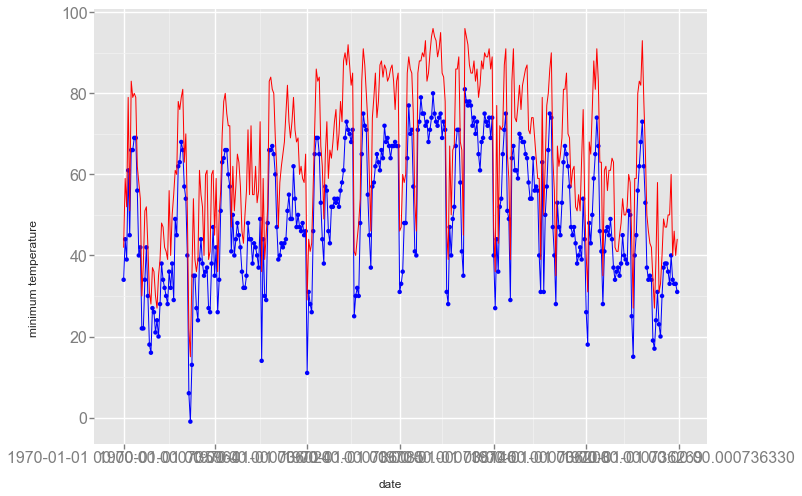

<ggplot: (157466912993)>

In [43]:
from ggplot import *
weather.date = pd.to_datetime(weather.date)
weather['day_of_year']= weather.date.dt.dayofyear
p = ggplot(aes(x='date'),data=weather) + geom_line(aes(y='minimum temperature', colour = "blue")) + geom_line(aes(y='maximum temperature', colour = "red"))
p + geom_point(aes(y='minimum temperature',colour = "blue")) #+ stat_smooth(colour='yellow', span=0.2)

下雪，降雨，积雪情况

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
weather['precipitation'].unique()
weather['precipitation'] = np.where(weather['precipitation']=='T', '0.00',weather['precipitation'])
weather['precipitation'] = list(map(float, weather['precipitation']))
weather['snow fall'] = np.where(weather['snow fall']=='T', '0.00',weather['snow fall'])
weather['snow fall'] = list(map(float, weather['snow fall']))
weather['snow depth'] = np.where(weather['snow depth']=='T', '0.00',weather['snow depth'])
weather['snow depth'] = list(map(float, weather['snow depth']))

In [45]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
random_x = weather['date'].values
random_y0 = weather['precipitation']
random_y1 = weather['snow fall']
random_y2 = weather['snow depth']

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
random_x = weather['date'].values
random_y0 = weather['precipitation']
random_y1 = weather['snow fall']
random_y2 = weather['snow depth']

# Create traces
trace0 = go.Scatter(
    x = random_x,
    y = random_y0,
    mode = 'markers',
    name = 'precipitation'
)
trace1 = go.Scatter(
    x = random_x,
    y = random_y1,
    mode = 'markers',
    name = 'snow fall'
)
trace2 = go.Scatter(
    x = random_x,
    y = random_y2,
    mode = 'markers',
    name = 'snow depth'
)

data = [trace0, trace1, trace2]
plotly.offline.iplot(data, filename='scatter-mode')


动作方向

In [46]:
def freq_turn(step_dir):
    """function to create dummy for turn type"""
    from collections import Counter
    step_dir_new = step_dir.split("|")
    a_list = Counter(step_dir_new).most_common()
    path = {}
    for i in range(len(a_list)):
        path.update({a_list[i]})
    a = 0
    b = 0
    c = 0
    if 'straight' in (path.keys()):
        a = path['straight']
        #print(a)
    if 'left' in (path.keys()):
        b = path['left']
        #print(b)
    if 'right' in (path.keys()):
        c = path['right']
        #print(c)
    return a,b,c

In [47]:
start = time.time()
train_fr['straight']= 0
train_fr['left'] =0
train_fr['right'] = 0
train_fr['straight'], train_fr['left'], train_fr['right'] = zip(*train_fr['step_direction'].map(freq_turn))
end = time.time()
print("Time Taken by above cell is {}.".format(end - start))

Time Taken by above cell is 12.961659669876099.


In [48]:
train_fr_new = train_fr[['id','straight','left','right']]
train = pd.merge(train, train_fr_new, on = 'id', how = 'left')
#train = pd.merge(train, weather, on= 'date', how = 'left')
print(len(train.columns))
#train.columns

47


In [49]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,speed_hvsn,speed_manhtn,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,store_and_fwd_flag_int,straight,left,right
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0.009087,0.010524,0.007691,0.017053,-0.009666,0.013695,0,2.0,1.0,1.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0.005438,0.007321,0.007677,-0.012371,0.027145,-0.018652,0,0.0,2.0,2.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0.008318,0.010687,0.004803,0.012879,0.034222,-0.039337,0,3.0,4.0,5.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0.006300,0.007046,0.038342,-0.029194,0.041343,-0.042293,0,0.0,2.0,1.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0.008484,0.008561,-0.002877,0.041749,-0.002380,0.031071,0,0.0,2.0,2.0


加入天气特征

In [50]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['date'] = train['pickup_datetime'].dt.date
train.head()

train['date'] = pd.to_datetime(train['date'])
train = pd.merge(train, weather[['date','minimum temperature', 'precipitation', 'snow fall', 'snow depth']], on= 'date', how = 'left')
train.shape[0]

1458644

In [51]:
train.loc[:,'hvsine_pick_cent_d'] = haversine_(train['pickup_latitude'].values, train['pickup_longitude'].values, train['centroid_drop_lat'].values, train['centroid_drop_long'].values)
train.loc[:,'hvsine_drop_cent_p'] = haversine_(train['dropoff_latitude'].values, train['dropoff_longitude'].values, train['centroid_pick_lat'].values, train['centroid_pick_long'].values)

test.loc[:,'hvsine_pick_cent_d'] = haversine_(test['pickup_latitude'].values, test['pickup_longitude'].values, test['centroid_drop_lat'].values, test['centroid_drop_long'].values)
test.loc[:,'hvsine_drop_cent_p'] = haversine_(test['dropoff_latitude'].values, test['dropoff_longitude'].values, test['centroid_pick_lat'].values, test['centroid_pick_long'].values)

print("shape of train_features is {}.".format(len(train.columns)))

shape of train_features is 54.


测试集才用相同的特征

In [52]:
start = time.time()
test_fr['straight']= 0
test_fr['left'] =0
test_fr['right'] = 0
test_fr['straight'], test_fr['left'], test_fr['right'] = zip(*test_fr['step_direction'].map(freq_turn))
end = time.time()
print("Time Taken by above cell is {}.".format(end - start))
#test_fr.head()

Time Taken by above cell is 5.300434827804565.


In [53]:
test_fr_new = test_fr[['id','straight','left','right']]
test = pd.merge(test, test_fr_new, on = 'id', how = 'left')
print(len(test.columns))
#test.columns

47


In [54]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
test['date'] = test['pickup_datetime'].dt.date
test['date'] = pd.to_datetime(test['date'])

In [55]:
test= pd.merge(test, weather[['date','minimum temperature', 'precipitation', 'snow fall', 'snow depth']], on= 'date', how = 'left')
feature_names = list(train.columns)
print("Difference of features in train and test are {}".format(np.setdiff1d(train.columns, test.columns)))
print("")
do_not_use_for_training = ['pick_date','id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'store_and_fwd_flag', 'date']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("We will be using following features for training {}.".format(feature_names))
print("")
print("Total number of features are {}.".format(len(feature_names)))

Difference of features in train and test are ['dropoff_datetime' 'trip_duration']

We will be using following features for training ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'total_distance', 'total_travel_time', 'number_of_steps', 'pick_month', 'hour', 'week_of_year', 'day_of_year', 'day_of_week', 'hvsine_pick_drop', 'manhtn_pick_drop', 'bearing', 'label_pick', 'label_drop', 'centroid_pick_long', 'centroid_pick_lat', 'centroid_drop_long', 'centroid_drop_lat', 'hvsine_pick_cent_p', 'hvsine_drop_cent_d', 'hvsine_cent_p_cent_d', 'manhtn_pick_cent_p', 'manhtn_drop_cent_d', 'manhtn_cent_p_cent_d', 'bearing_pick_cent_p', 'bearing_drop_cent_p', 'bearing_cent_p_cent_d', 'speed_hvsn', 'speed_manhtn', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'store_and_fwd_flag_int', 'straight', 'left', 'right', 'minimum temperature', 'precipitation', 'snow fall', 'snow depth', 'hvsine_pick_cent_d', 'hvsine_drop_cent_p']

In [56]:
y = np.log(train['trip_duration'].values + 1)

再次训练模型

In [62]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

start = time.time()
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model_1 = xgb.train(xgb_par, dtrain, 100, watchlist, early_stopping_rounds=4, maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)
end = time.time()
print("Time taken in training is {}.".format(end - start))


[0]	train-rmse:5.72042	valid-rmse:5.72132
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 4 rounds.
[1]	train-rmse:5.43622	valid-rmse:5.43719
[2]	train-rmse:5.16677	valid-rmse:5.16779
[3]	train-rmse:4.91052	valid-rmse:4.91162
[4]	train-rmse:4.6672	valid-rmse:4.66837
[5]	train-rmse:4.43612	valid-rmse:4.43735
[6]	train-rmse:4.21655	valid-rmse:4.21782
[7]	train-rmse:4.00819	valid-rmse:4.00953
[8]	train-rmse:3.81012	valid-rmse:3.81151
[9]	train-rmse:3.62209	valid-rmse:3.62354
[10]	train-rmse:3.44373	valid-rmse:3.44527
[11]	train-rmse:3.2744	valid-rmse:3.27601
[12]	train-rmse:3.11365	valid-rmse:3.11535
[13]	train-rmse:2.9613	valid-rmse:2.96308
[14]	train-rmse:2.81629	valid-rmse:2.81817
[15]	train-rmse:2.67887	valid-rmse:2.68086
[16]	train-rmse:2.54841	valid-rmse:2.55053
[17]	train-rmse:2.42448	valid-rmse:2.42672
[18]	train-rmse:2.30707	valid-rmse:2.30944
[19]	train-rmse:2.19537	valid-rmse:2.19787
[20]	trai

In [58]:
print('Modeling RMSLE %.5f' % model_1.best_score)
end = time.time()
print("Time taken in training is {}.".format(end - start))
start = time.time()
yvalid = model_1.predict(dvalid)
ytest = model_1.predict(dtest)
end = time.time()
print("Time taken in prediction is {}.".format(end - start))

Modeling RMSLE 3.62354
Time taken in training is 16.804673671722412.
Time taken in prediction is 0.07018685340881348.


In [59]:
start = time.time()
if test.shape[0] == ytest.shape[0]:
    print('Test shape OK.') 
test['trip_duration'] = np.exp(ytest) - 1
test[['id', 'trip_duration']].to_csv('mahesh_xgb_submission.csv', index=False)
end = time.time()
print("Time taken in training is {}.".format(end - start))

Test shape OK.
Time taken in training is 1.3792648315429688.
